# Pitfalls of retrieval - When simple vector search fails!
## Introduction
In this lesson we'll show that semantic similarities is not always that perfect

Visualize Relavancy and Destractions 

## Installation

In [1]:
%pip install -q -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Connecting to our existing Vector database

In [2]:
import chromadb
from helper_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from chromadb.config import DEFAULT_TENANT, DEFAULT_DATABASE, Settings

chroma_client = chromadb.PersistentClient(
    path="data/chroma_db/",
    settings=Settings(),
    tenant=DEFAULT_TENANT,
    database=DEFAULT_DATABASE,
)
# Load the existing collection by its name
collection_name = 'microsoft_annual_report_2022'
chroma_collection = chroma_client.get_or_create_collection(name=collection_name)

# Count the number of items in the collection
count = chroma_collection.count()
print(f"Number of items in the collection '{collection_name}': {count}")

Number of items in the collection 'microsoft_annual_report_2022': 349


## Setting up the embedding model

In [3]:
# Access the underlying SentenceTransformer model (Defults)
embedding_function = SentenceTransformerEmbeddingFunction()
model = embedding_function.models
print(model)

/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'all-MiniLM-L6-v2': SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)}


## Helper function to show the results from a vector search

In [4]:
def print_results_and_documents(results, retrieved_documents, word_wrap):
    """
    Prints keys and values from the results dictionary and documents with word wrapping.

    Args:
        results (dict): A dictionary where keys are strings and values are either strings or lists.
        retrieved_documents (list): A list of documents to be printed.
        word_wrap (function): A function to apply word wrapping to the documents.

    Returns:
        None
    """
    # Iterate through the dictionary and print each key with its associated value
    for key, value in results.items():
        print(f"{key}:")

        # Check if the value is a list and print its elements
        if isinstance(value, list):
            for i, item in enumerate(value):
                print(f"  Item {i+1}: {item}")
        else:
            # Directly print the value if it's not a list
            print(f"  {value}")

        print()  # Add a newline for better readability

    # Iterate through the list of documents and print each one with word wrapping
    for document in retrieved_documents:
        print(word_wrap(document))
        print('\n')


## Visualize the embeddings

In [5]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

In [6]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [7]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

  0%|          | 0/349 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/349 [00:01<06:17,  1.09s/it]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwil

(0.7186514556407928, 10.606608587503434, 7.177721071243286, 14.084149312973022)

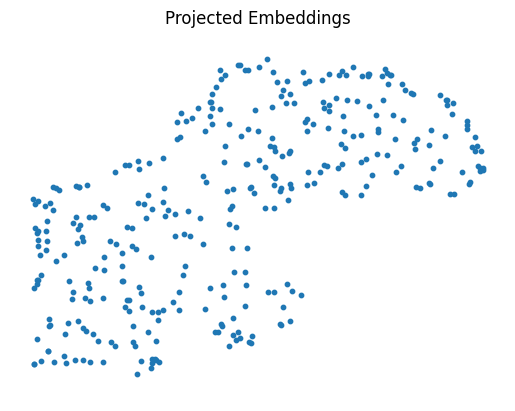

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

This what our vector looks like in 2D

## Visualizing the result of a query

In [16]:
query = "What is the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=10, include=['documents', 'embeddings', "distances"])
retrieved_documents = results['documents'][0]

print_results_and_documents(results, retrieved_documents, word_wrap)

ids:
  Item 1: ['293', '168', '320', '319', '210', '331', '323', '194', '322', '169']

embeddings:
  Item 1: [[-0.03879594 -0.00056903 -0.00237735 ... -0.09649955 -0.03808513
  -0.07317519]
 [-0.07776321 -0.02667234  0.00320032 ... -0.13042937 -0.00600811
  -0.06882532]
 [ 0.052216   -0.03315055  0.03330245 ... -0.07793505 -0.00250688
  -0.02969674]
 ...
 [-0.00725529 -0.00870073  0.02653533 ... -0.08715806 -0.03856301
  -0.07218203]
 [ 0.00954385  0.02305174  0.01527969 ... -0.12848613 -0.01325813
  -0.06478965]
 [-0.02551503 -0.03758026 -0.00709907 ... -0.09984561 -0.0017376
  -0.02891093]]

documents:
  Item 1: ['74 note 13 — unearned revenue unearned revenue by segment was as follows : ( in millions ) june 30, 2022 2021 productivity and business processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in unearned revenue were as follows : ( in millions ) year ended june 30, 2022 balance, beginning of per

In [17]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


  0%|          | 0/1 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/

(0.7186514556407928, 10.606608587503434, 7.177721071243286, 14.084149312973022)

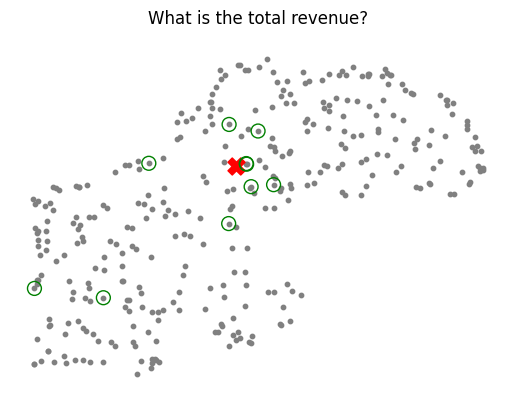

In [18]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

Play around with the n_results (try 2 then 10)

Note: The one chucnk seems far away however, the 384 dimensions have been collapsed into 2D. 

## Another query

In [19]:
query = "What is the strategy around artificial intelligence (AI) ?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', "distances"])
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', "distances"])
retrieved_documents = results['documents'][0]

print_results_and_documents(results, retrieved_documents, word_wrap)

ids:
  Item 1: ['40', '18', '14', '19', '106']

embeddings:
  Item 1: [[-0.000718   -0.05684617 -0.00857462 ... -0.04680487  0.00381006
  -0.03325919]
 [ 0.0056523   0.01431411 -0.02756493 ... -0.0557157   0.04644812
  -0.03231423]
 [-0.01871965 -0.00935099  0.02255296 ...  0.0115429   0.02689471
  -0.00566612]
 [-0.00750419 -0.08407906 -0.01892814 ... -0.02157405 -0.00838311
   0.0145357 ]
 [-0.06899783 -0.06819993  0.010729   ... -0.00015865  0.02435512
   0.04392653]]

documents:
  Item 1: ['culture of trust can help navigate the challenges the world faces today. organizations of all sizes have digitized business - critical functions, redefining what they can expect from their business applications. customers are looking to unlock value while simplifying security and management. from infrastructure and data, to business applications and collaboration, we provide unique, differentiated value to customers. we are building a distributed computing fabric – across cloud and the edge – to

Note: This sentence is what probably gave it the closest distance.

 "we are building a distributed computing fabric – across cloud and the edge – to help every organization build, run, and manage mission - critical workloads anywhere. in the next phase of innovation, artificial intelligence ( “ ai ” ) capabilities are rapidly advancing, fueled by data and knowledge of the world."

In [20]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


  0%|          | 0/1 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/v

(0.7186514556407928, 10.606608587503434, 7.177721071243286, 14.084149312973022)

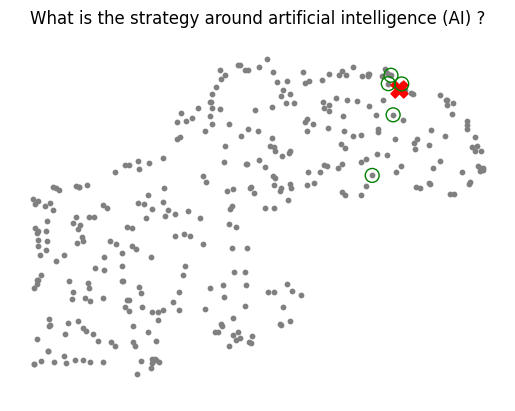

In [21]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

This is an example of distractors. These are rsults that might distract if passed to the LLM. 

In [27]:
query = "What has been the investment in research and development?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', "distances"])
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', "distances"])
retrieved_documents = results['documents'][0]

print_results_and_documents(results, retrieved_documents, word_wrap)

ids:
  Item 1: ['150', '111', '110', '3', '63']

embeddings:
  Item 1: [[ 0.03424561 -0.02174987  0.021612   ... -0.13505781  0.03808352
   0.01734272]
 [-0.01441707 -0.05460839  0.01334853 ... -0.05926889  0.01319222
   0.01866412]
 [ 0.00234855 -0.08959572 -0.002995   ... -0.09327996  0.02772185
   0.04354688]
 [-0.04978053 -0.05906971 -0.02249595 ... -0.09754975 -0.04274867
   0.04632248]
 [-0.03640772 -0.04901733 -0.03524242 ... -0.14201681 -0.08190151
   0.02395314]]

documents:
  Item 1: ['• operating expenses increased $ 1. 5 billion or 14 % driven by investments in gaming, search and news advertising, and windows marketing. operating expenses research and development ( in millions, except percentages ) 2022 2021 percentage change research and development $ 24, 512 $ 20, 716 18 % as a percent of revenue 12 % 12 % 0ppt research and development expenses include payroll, employee benefits, stock - based compensation expense, and other headcount - related expenses associated with pr

Note: IDs 110 3 and 63 are considered distractors. If they are passed to an LLM it's harder to debug. 

In [28]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


  0%|          | 0/1 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/v

(0.7186514556407928, 10.606608587503434, 7.177721071243286, 14.084149312973022)

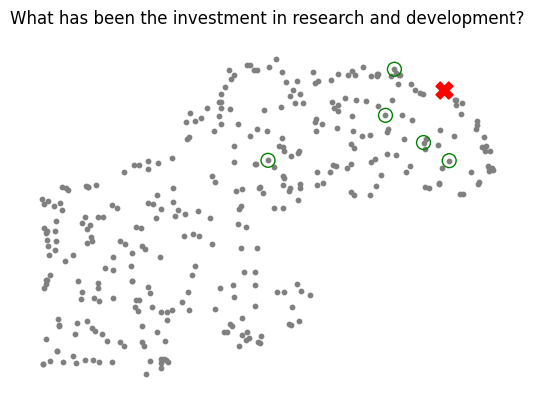

In [29]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

Irrelevant queries. 

Try some other queries. 

In [30]:
query = "What has Michael Jordan done for us lately?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', "distances"])
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', "distances"])
retrieved_documents = results['documents'][0]

#print_results_and_documents(results, retrieved_documents, word_wrap)

In [31]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


  0%|          | 0/1 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/v

(0.7186514556407928, 10.606608587503434, 7.177721071243286, 14.084149312973022)

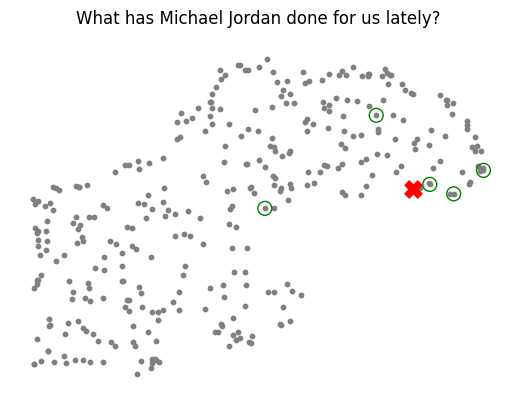

In [32]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')